## Imports

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rcParams
import pandas as pd
import math
import numpy as np

from pathlib import Path

import seaborn as sns
sns.set_theme()

import warnings
def relplot(*args, **kwargs):
        
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        return sns.relplot(*args, **kwargs)


results_path = Path('/home/selker/eop/eop/run_simulations/results')
figs_path = Path('/home/selker/eop/eop/run_simulations/figs')
figs_path.mkdir(exist_ok=True)

malawi = pd.read_parquet('/home/selker/eop/data/malawi/malawi_cleaned_2019.parquet')

## Comparing gap and rate targeting

In [80]:
gap_targeting_results = pd.read_csv(results_path / 'gap' / 'malawi.csv')

gap_targeting_results.loc[gap_targeting_results.features == 'selected_durable', 'method'] = (
    'gap (30 covariates)'
)
gap_targeting_results.loc[gap_targeting_results.features == 'all_durable', 'method'] = (
    'gap (147 covariates)'
)
gap_targeting_results.loc[gap_targeting_results.features == '4_selected_durable', 'method'] = (
    'gap (4 covariates)'
)
gap_targeting_results.loc[gap_targeting_results.features == 'EA', 'method'] = (
    'gap (EA fixed effects)'
)
gap_targeting_results.loc[gap_targeting_results.features == 'district', 'method'] = (
    'gap (district fixed effects)'
)
gap_targeting_results.loc[gap_targeting_results.features == 'mosaiks', 'method'] = (
    'gap (mosaiks features)'
)
gap_targeting_results.loc[gap_targeting_results.features == 'mosaiks_and_durable', 'method'] = (
    'gap (147 covariates and mosaiks features)'
)

rate_targeting_results = pd.read_csv(results_path / 'rate_for_gap_comparison' / 'malawi.csv')
rate_targeting_results.method = 'rate (30 covariates)'

oracle_gap_targeting_results = pd.read_csv(results_path / 'oracle_gap' / 'malawi.csv')
oracle_gap_targeting_results['method'] = (
    'oracle gap'
)


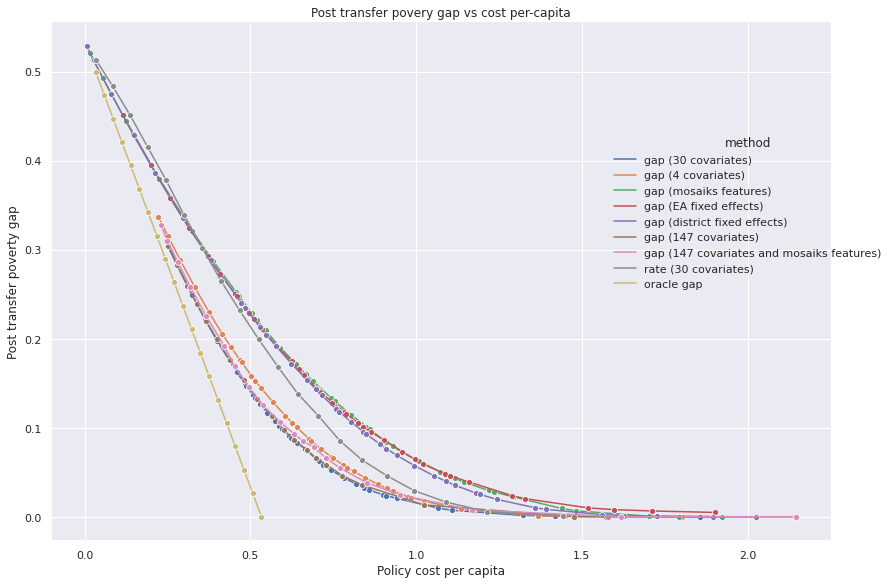

In [82]:
gap_comparison = pd.concat((gap_targeting_results, rate_targeting_results, oracle_gap_targeting_results))
gap_comparison.drop_duplicates(
    subset=[
        'method', 'unconditional_tolerance', 'conditional_tolerance', 'd', 'nclass', 
        'features', 'lambda', 'n_quantiles', 'hidden_layer_size', 'scheme'
    ],
    keep='last', inplace=True
)

fg = relplot(
    data=gap_comparison, kind='line',
    x="policy_cost_per_capita", y="post_transfer_poverty_gap", hue="method",
    marker='o', height=8, aspect=12/8
)
fg.set(
    xlabel='Policy cost per capita', ylabel='Post transfer poverty gap', 
    title='Post transfer povery gap vs cost per-capita'
)
sns.move_legend(fg, "upper right",bbox_to_anchor=(.8,.8))

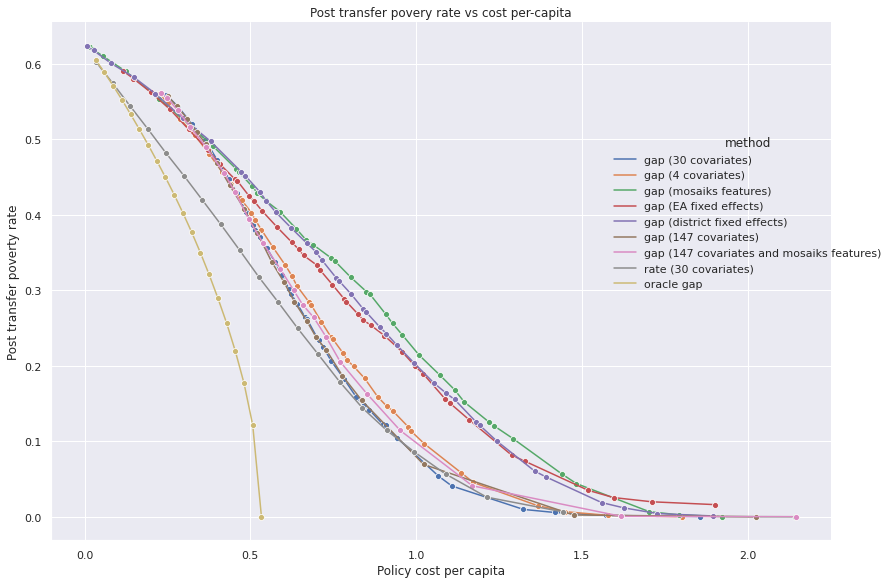

In [83]:
fg = relplot(
    data=gap_comparison, kind='line',
    x="policy_cost_per_capita", y="post_transfer_poverty_rate", hue="method",
    marker='o', height=8, aspect=12/8
)
fg.set(
    xlabel='Policy cost per capita', ylabel='Post transfer poverty rate', 
    title='Post transfer povery rate vs cost per-capita'
)
sns.move_legend(fg, "upper right",bbox_to_anchor=(.8,.8))

## Gap targeting parameter search

In [65]:
gap_targeting_parameter_search_results = pd.read_csv(results_path / 'gap_parameter_search' / 'malawi.csv')

gap_targeting_parameter_search_results.drop_duplicates(
    subset=[
        'method', 'unconditional_tolerance', 'conditional_tolerance', 'd', 'nclass', 
        'features', 'lambda', 'n_quantiles', 'hidden_layer_size'
    ],
    keep='last', inplace=True
)

gap_targeting_parameter_search_results.rename(
    columns={
        'n_quantiles': 'Number of quantiles fit',
        'hidden_layer_size': 'Neurons in hidden layer',
    }, 
    inplace=True
)

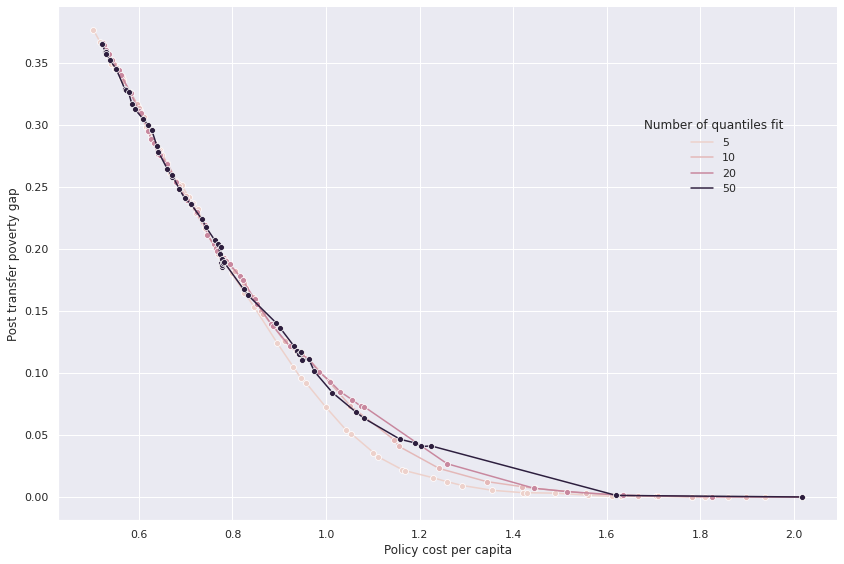

In [62]:
to_plot=gap_targeting_parameter_search_results[
    (gap_targeting_parameter_search_results['Neurons in hidden layer'] == 64)
    & (gap_targeting_parameter_search_results['features'] == 'all_durable')
]
fg = relplot(
    data=to_plot, kind='line',
    x="policy_cost_per_capita", y="post_transfer_poverty_rate", hue="Number of quantiles fit",
    marker='o', height=8, aspect=12/8
)
fg.set(xlabel='Policy cost per capita', ylabel='Post transfer poverty gap')
sns.move_legend(fg, "upper right",bbox_to_anchor=(.8,.8))

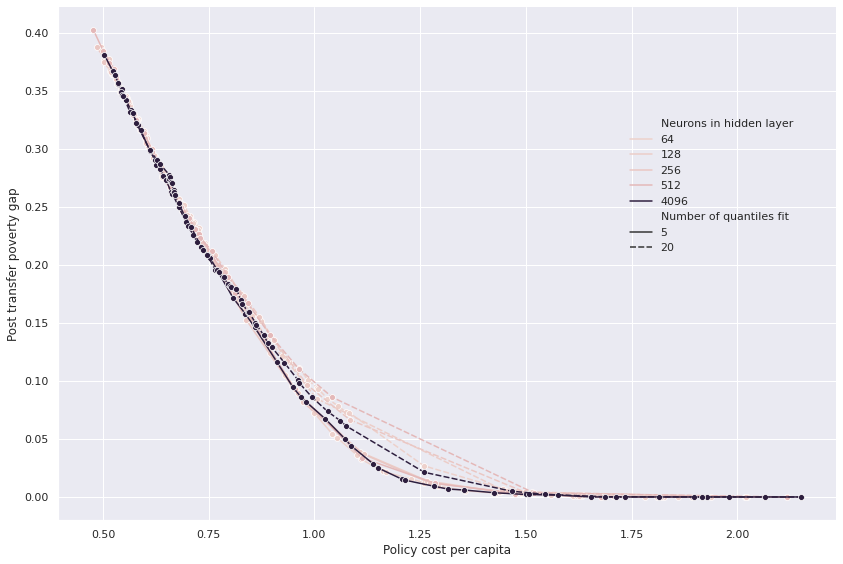

In [63]:
to_plot=gap_targeting_parameter_search_results[
    (gap_targeting_parameter_search_results['Number of quantiles fit'].isin([5,20]))
    & (gap_targeting_parameter_search_results['features'] == 'all_durable')

]
fg = relplot(
    data=to_plot, kind='line',
    x="policy_cost_per_capita", y="post_transfer_poverty_rate", hue="Neurons in hidden layer",
    style='Number of quantiles fit',
    marker='o', height=8, aspect=12/8
)
fg.set(xlabel='Policy cost per capita', ylabel='Post transfer poverty gap')
sns.move_legend(fg, "upper right",bbox_to_anchor=(.8,.8))

In [ ]:
to_plot=gap_targeting_parameter_search_results[
    (gap_targeting_parameter_search_results['features'] == 'mosaiks')
    & (gap_targeting_parameter_search_results['Neurons in hidden layer'] != 5000)
    #& (gap_targeting_parameter_search_results['Number of quantiles fit'] == 20)

]
fg = relplot(
    data=to_plot, kind='line',
    x="policy_cost_per_capita", y="post_transfer_poverty_rate", hue="Neurons in hidden layer",
    style='Number of quantiles fit',
    marker='o', height=8, aspect=12/8
)
fg.set(xlabel='Policy cost per capita', ylabel='Post transfer poverty gap')
sns.move_legend(fg, "upper right",bbox_to_anchor=(.8,.8))

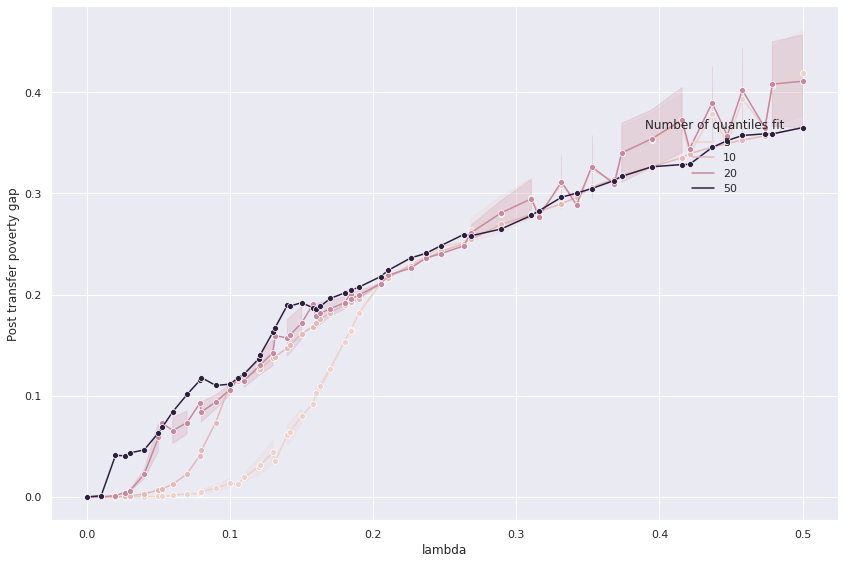

In [65]:
to_plot=gap_targeting_parameter_search_results[
    gap_targeting_parameter_search_results['Neurons in hidden layer'] == 64
]
fg = relplot(
    data=to_plot, kind='line',
    x="lambda", y="post_transfer_poverty_rate", hue="Number of quantiles fit",
    marker='o', height=8, aspect=12/8
)
fg.set(ylabel='Post transfer poverty gap')
sns.move_legend(fg, "upper right",bbox_to_anchor=(.8,.8))

## With and without TA fixed effects

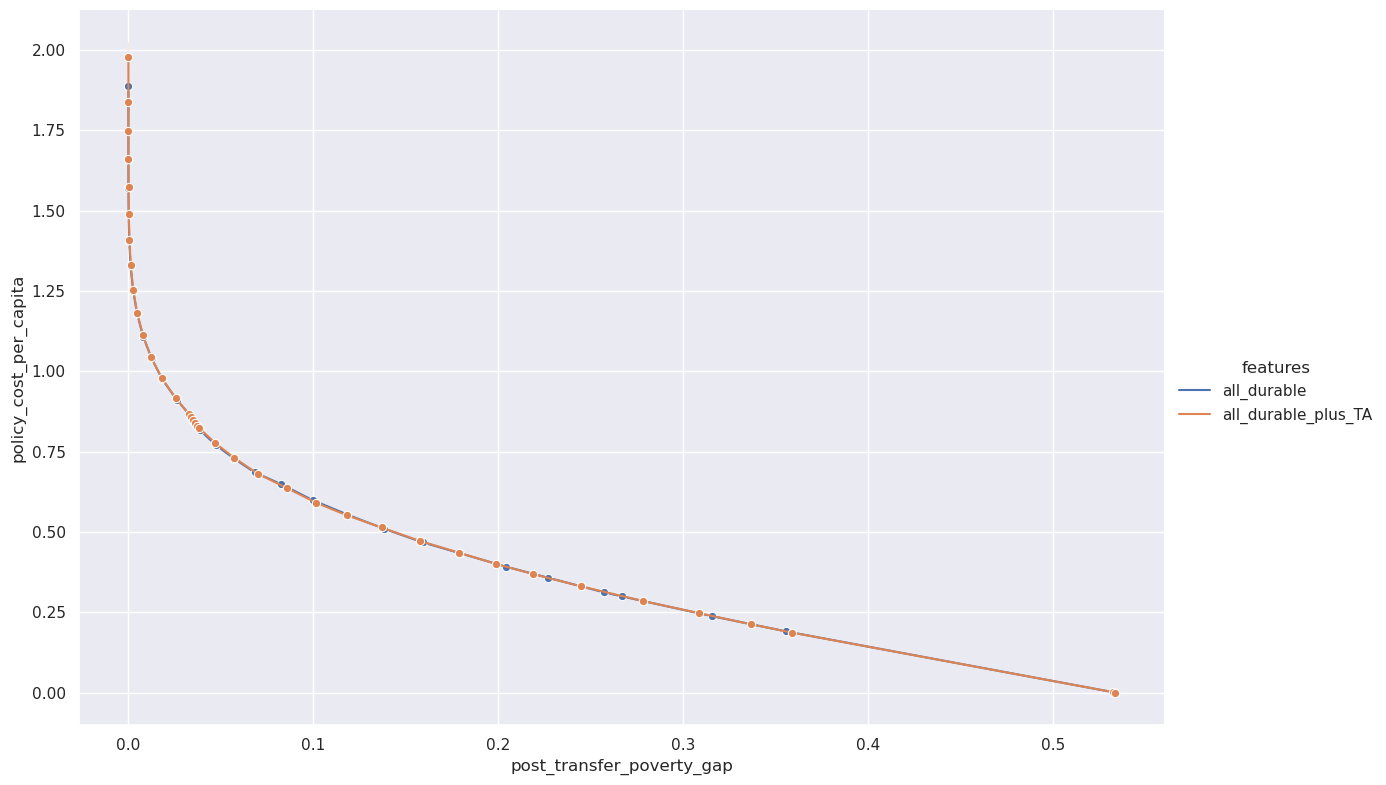

In [7]:
with_and_without_ta = pd.read_csv(results_path / 'gap_with_and_without_TA' / 'malawi.csv')
with_and_without_ta.drop_duplicates(
    subset=[
        'features', 'lambda'
    ],
    keep='last', inplace=True
)

fig = relplot(
    data=with_and_without_ta, x='post_transfer_poverty_gap', y='policy_cost_per_capita',
    hue='features',  kind='line', marker='o', height=8, aspect=12/8
)

## Top-line plots


#### Setup

In [3]:
def evaluate_ratios(numerator_data: pd.DataFrame, denominator_data: pd.DataFrame, desired_field, matching_field, matching_values):

    numerator_data = numerator_data.copy().sort_values(matching_field)
    denominator_data = denominator_data.copy().sort_values(matching_field)

    numerator = np.interp(x=matching_values, xp=numerator_data[matching_field], fp=numerator_data[desired_field])
    denominator = np.interp(x=matching_values, xp=denominator_data[matching_field], fp=denominator_data[desired_field])

    return numerator / denominator

### Rate vs Gap targeting comparison

In [6]:

continuous_unconditional_rate = pd.read_csv(results_path / 'top_line' / 'continuous_unconditional_rate' / 'malawi.csv')
continuous_unconditional_rate.rename(columns={'method': 'policy_type'}, inplace=True)
continuous_unconditional_rate.policy_type = 'rate (30 covariates)'

continuous_unconditional_rate_3_covariates = pd.read_csv(results_path / 'top_line' / 'continuous_unconditional_rate_3_covariates' / 'malawi.csv')
continuous_unconditional_rate_3_covariates.policy_type = 'rate (3 covariates)'

continuous_gap = pd.read_csv(results_path / 'top_line'  / 'continuous_gap' / 'malawi.csv')

oracle_rate = pd.read_csv(results_path / 'top_line' / 'oracle_rate' / 'malawi.csv')
oracle_rate.policy_type = 'oracle rate'
oracle_gap = pd.read_csv(results_path / 'top_line' / 'oracle_gap' / 'malawi.csv')
oracle_gap.policy_type = 'oracle gap'


gap_rate_comparison = pd.concat((
    continuous_unconditional_rate, continuous_gap, oracle_rate, oracle_gap, continuous_unconditional_rate_3_covariates
    ))
gap_rate_comparison.drop_duplicates(
    subset=[
        'policy_type', 'unconditional_tolerance', 'conditional_tolerance', 'd', 'nclass', 
        'features', 'lambda'
    ],
    keep='last', inplace=True
)


/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarn

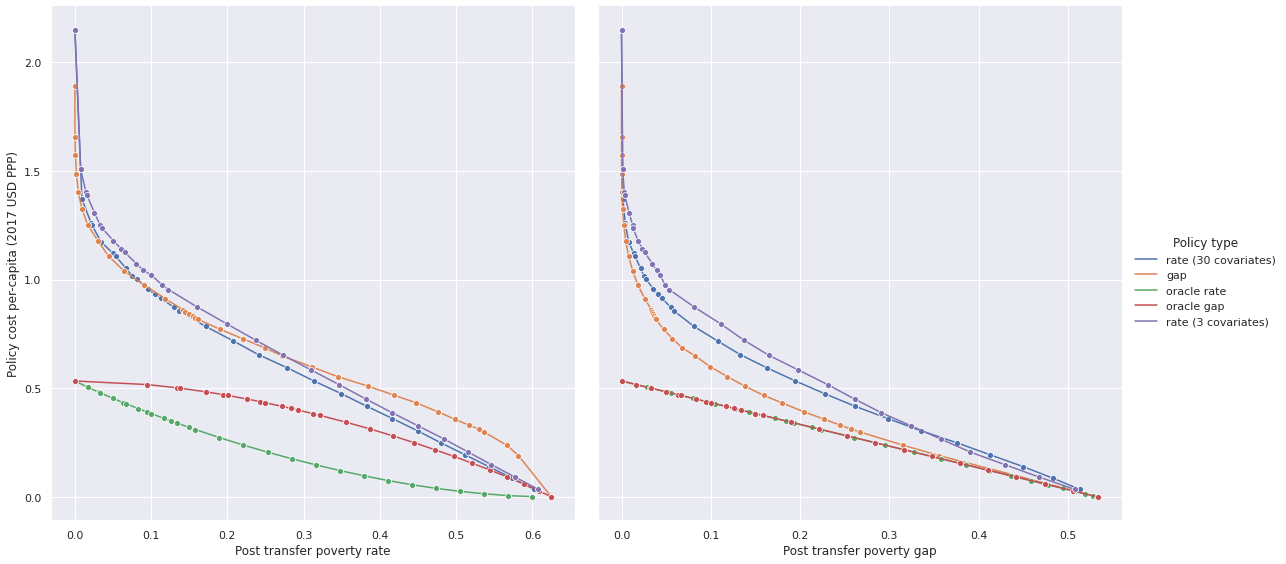

In [7]:
to_plot = gap_rate_comparison.copy()

to_plot.rename(
    columns={
        'policy_type': 'Policy type',
        'post_transfer_poverty_rate': 'Post transfer poverty rate',
        'post_transfer_poverty_gap': 'Post transfer poverty gap'
    }, 
inplace=True)

#to_plot.loc[to_plot['Policy type'] == 'oracle gap', 'Post transfer poverty rate'] = None

fg = sns.PairGrid(
    data=to_plot,
    x_vars=('Post transfer poverty rate', 'Post transfer poverty gap'),
    y_vars=('policy_cost_per_capita'),
    hue='Policy type',
    height=8,
)
fg.map(
    sns.lineplot,
    marker='o',
)
fg.set(ylabel='Policy cost per-capita (2017 USD PPP)')
# fg.figure.suptitle('Poverty rate and gap targeting performance')
fg.add_legend()


### Ratios vs oracles

In [24]:

continuous_unconditional_rate = pd.read_csv(results_path / 'top_line' / 'continuous_unconditional_rate' / 'malawi.csv')
continuous_unconditional_rate.rename(columns={'method': 'policy_type'}, inplace=True)

continuous_gap = pd.read_csv(results_path / 'top_line'  / 'continuous_gap' / 'malawi.csv')

oracle_gap = pd.read_csv(results_path / 'top_line' / 'oracle_gap' / 'malawi.csv')
oracle_rate = pd.read_csv(results_path / 'top_line' / 'oracle_rate' / 'malawi.csv')


oracle_comparison_data = pd.concat((continuous_unconditional_rate, continuous_gap, oracle_rate, oracle_gap))
oracle_comparison_data.drop_duplicates(
    subset=[
        'policy_type', 'unconditional_tolerance', 'conditional_tolerance', 'd', 'nclass', 
        'features', 'lambda'
    ],
    keep='last', inplace=True
)


### By rate, vs oracle rate

In [25]:
max_post_transfer_rate = oracle_comparison_data.groupby('policy_type').agg({'post_transfer_poverty_rate': 'max'}).min().values.item()

rates_to_evaluate_ratios = np.linspace(0, max_post_transfer_rate, 40)

gap_targeting_ratios_by_rate = evaluate_ratios(
    numerator_data=oracle_comparison_data[oracle_comparison_data.policy_type == 'gap'],
    denominator_data=oracle_comparison_data[oracle_comparison_data.policy_type == 'oracle_rate'],
    desired_field='policy_cost_per_capita',
    matching_field='post_transfer_poverty_rate',
    matching_values=rates_to_evaluate_ratios
)
gap_targeting_ratios_by_rate = pd.DataFrame(
    np.array([rates_to_evaluate_ratios, gap_targeting_ratios_by_rate]).transpose(),
    columns=['post_transfer_poverty_rate', 'cost_ratio']
)
gap_targeting_ratios_by_rate['policy_type'] = 'gap'

rate_targeting_ratios_by_rate = evaluate_ratios(
    numerator_data=oracle_comparison_data[oracle_comparison_data.policy_type == 'unconditional'],
    denominator_data=oracle_comparison_data[oracle_comparison_data.policy_type == 'oracle_rate'],
    desired_field='policy_cost_per_capita',
    matching_field='post_transfer_poverty_rate',
    matching_values=rates_to_evaluate_ratios
)
rate_targeting_ratios_by_rate = pd.DataFrame(
    np.array([rates_to_evaluate_ratios, rate_targeting_ratios_by_rate]).transpose(),
    columns=['post_transfer_poverty_rate', 'cost_ratio']
)
rate_targeting_ratios_by_rate['policy_type'] = 'rate'

ratios_by_rate = pd.concat((
    gap_targeting_ratios_by_rate,
    rate_targeting_ratios_by_rate
))


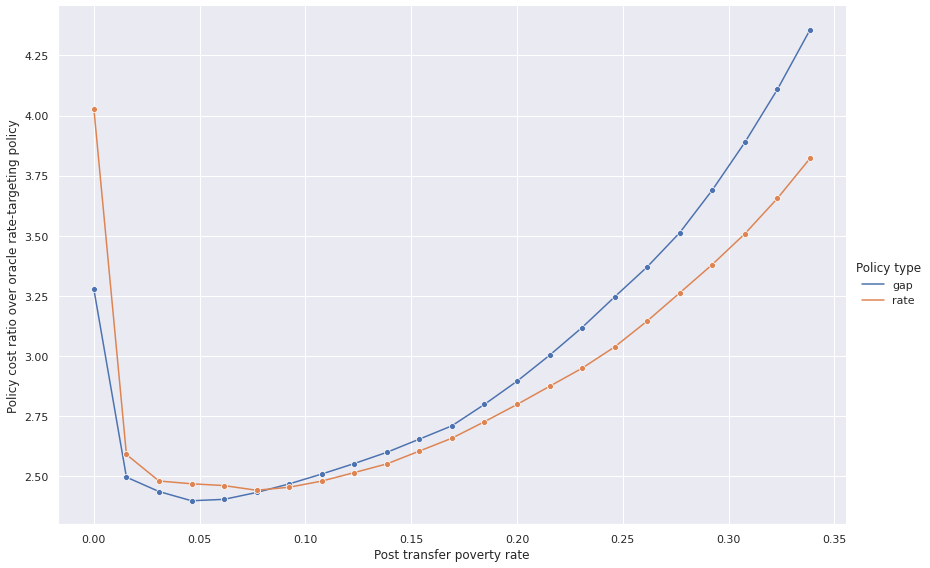

In [27]:
to_plot = ratios_by_rate.copy()

to_plot.rename(columns={'policy_type': 'Policy type'}, inplace=True)

max_post_transfer_rate_with_reasonable_oracle_cost = oracle_rate[
    oracle_rate.policy_cost_per_capita > 0.1
].post_transfer_poverty_rate.max()
to_plot = to_plot[to_plot.post_transfer_poverty_rate <= max_post_transfer_rate_with_reasonable_oracle_cost]

fg = relplot(
    data=to_plot, x='post_transfer_poverty_rate', y='cost_ratio',
    hue='Policy type', kind='line', marker='o', height=8, aspect=12/8
)
fg.set(xlabel='Post transfer poverty rate', ylabel='Policy cost ratio over oracle rate-targeting policy')
#sns.move_legend(fg, "upper right",bbox_to_anchor=(.8,.8))

#### By gap, vs oracle gap

In [28]:
max_post_transfer_gap = oracle_comparison_data.groupby('policy_type').agg({'post_transfer_poverty_gap': 'max'}).min().values.item()
gaps_to_evaluate_ratios = np.linspace(0, max_post_transfer_gap, 40)

gap_targeting_ratios_by_gap = evaluate_ratios(
    numerator_data=oracle_comparison_data[oracle_comparison_data.policy_type == 'gap'],
    denominator_data=oracle_comparison_data[oracle_comparison_data.policy_type == 'oracle_gap'],
    desired_field='policy_cost_per_capita',
    matching_field='post_transfer_poverty_gap',
    matching_values=gaps_to_evaluate_ratios
)
gap_targeting_ratios_by_gap = pd.DataFrame(
    np.array([gaps_to_evaluate_ratios, gap_targeting_ratios_by_gap]).transpose(),
    columns=['post_transfer_poverty_gap', 'cost_ratio']
)
gap_targeting_ratios_by_gap['policy_type'] = 'gap'

rate_targeting_ratios_by_gap = evaluate_ratios(
    numerator_data=oracle_comparison_data[oracle_comparison_data.policy_type == 'unconditional'],
    denominator_data=oracle_comparison_data[oracle_comparison_data.policy_type == 'oracle_gap'],
    desired_field='policy_cost_per_capita',
    matching_field='post_transfer_poverty_gap',
    matching_values=gaps_to_evaluate_ratios
)
rate_targeting_ratios_by_gap = pd.DataFrame(
    np.array([gaps_to_evaluate_ratios, rate_targeting_ratios_by_gap]).transpose(),
    columns=['post_transfer_poverty_gap', 'cost_ratio']
)
rate_targeting_ratios_by_gap['policy_type'] = 'rate'

ratios_by_gap = pd.concat((
    gap_targeting_ratios_by_gap,
    rate_targeting_ratios_by_gap
))


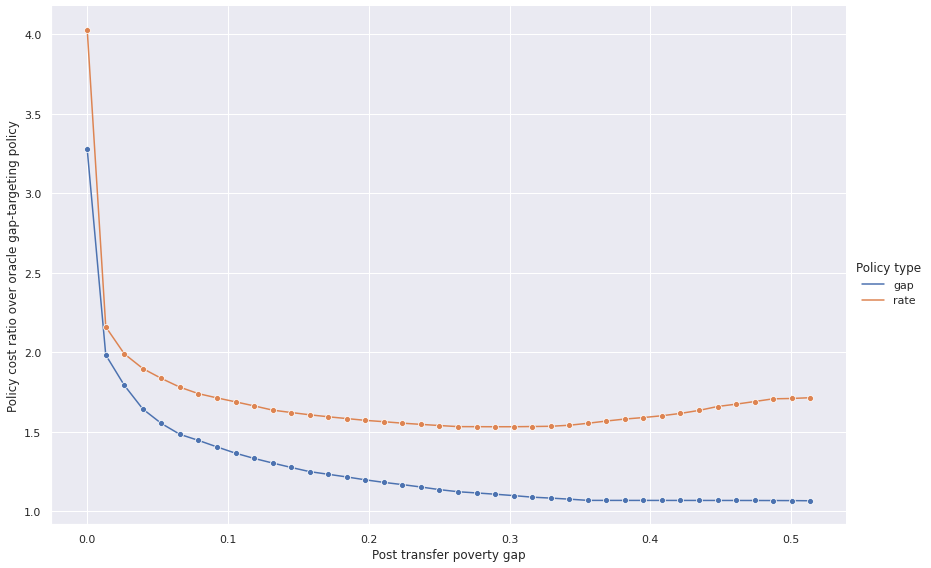

In [29]:
to_plot = ratios_by_gap.copy()

to_plot.rename(columns={'policy_type': 'Policy type'}, inplace=True)

fg = relplot(
    data=to_plot, x='post_transfer_poverty_gap', y='cost_ratio',
    hue='Policy type', kind='line', marker='o', height=8, aspect=12/8
)
fg.set(xlabel='Post transfer poverty gap', ylabel='Policy cost ratio over oracle gap-targeting policy')
#sns.move_legend(fg, "upper right",bbox_to_anchor=(.8,.8))

### Continuous vs binary

In [12]:
continuous_unconditional_rate = pd.read_csv(results_path / 'top_line' / 'continuous_unconditional_rate' / 'malawi.csv')
continuous_unconditional_rate.rename(columns={'method': 'policy_type'}, inplace=True)

binary_unconditional_rate = pd.read_csv(results_path / 'top_line' / 'binary_unconditional_rate' / 'malawi.csv')

continuous_vs_binary_rate = pd.concat((continuous_unconditional_rate, binary_unconditional_rate))
continuous_vs_binary_rate.drop_duplicates(
    subset=[
        'policy_type', 'unconditional_tolerance', 'conditional_tolerance', 'd', 'nclass', 
        'features'
    ],
    keep='last', inplace=True
)
continuous_vs_binary_rate.policy_type = continuous_vs_binary_rate.policy_type.map({'unconditional': 'continuous transfers', 'binary': 'binary transfers'})

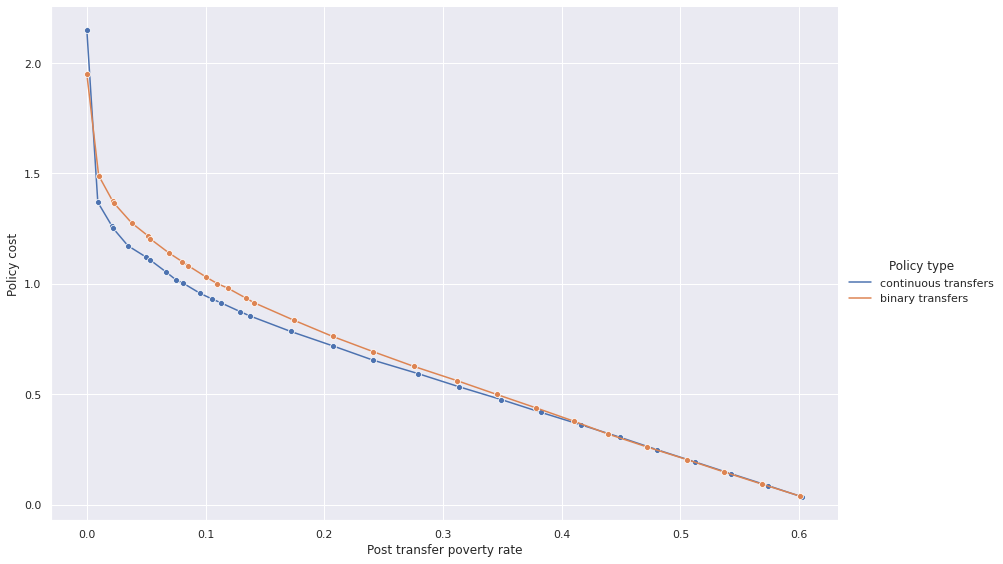

In [146]:
to_plot = continuous_vs_binary_rate.copy()

to_plot.rename(columns={'policy_type': 'Policy type'}, inplace=True)

fg = relplot(
    data=to_plot, x='post_transfer_poverty_rate', y='policy_cost_per_capita',
    hue='Policy type', kind='line', marker='o', height=8, aspect=12/8
)
fg.set(xlabel='Post transfer poverty rate', ylabel='Policy cost')
#sns.move_legend(fg, "upper right",bbox_to_anchor=(.8,.8))

In [40]:

max_post_transfer_rate = continuous_vs_binary_rate.groupby('policy_type').agg({'post_transfer_poverty_rate': 'max'}).min().values.item()
rates_to_evaluate_ratios = np.linspace(0, max_post_transfer_rate, 40)

rate_ratios = evaluate_ratios(
    numerator_data=continuous_vs_binary_rate[continuous_vs_binary_rate.policy_type == 'binary transfers'],
    denominator_data=continuous_vs_binary_rate[continuous_vs_binary_rate.policy_type == 'continuous transfers'],
    desired_field='policy_cost_per_capita',
    matching_field='post_transfer_poverty_rate',
    matching_values=rates_to_evaluate_ratios
)
rate_ratios = pd.DataFrame(
    np.array([rates_to_evaluate_ratios, rate_ratios]).transpose(),
    columns=['post_transfer_poverty_rate', 'cost_ratio']
)


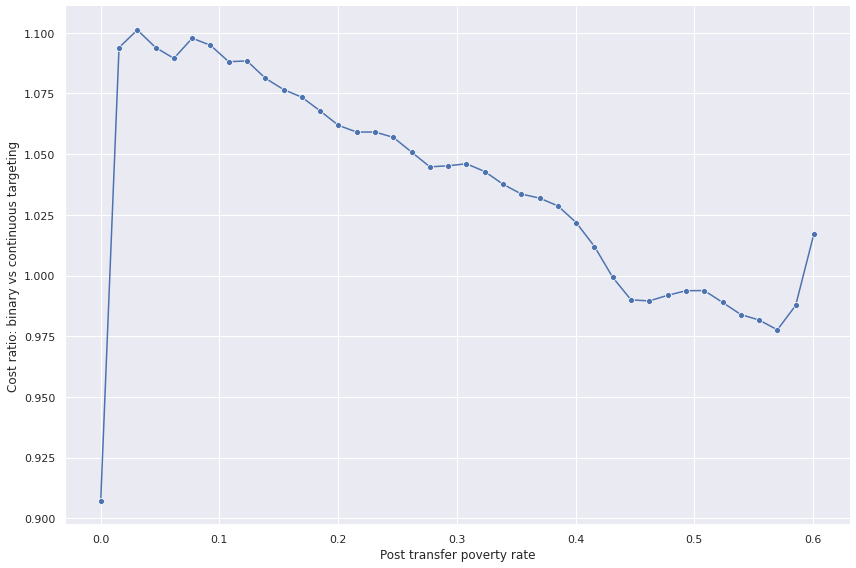

In [42]:
to_plot = rate_ratios.copy()

to_plot.rename(columns={'policy_type': 'Policy type'}, inplace=True)

fg = relplot(
    data=to_plot, x='post_transfer_poverty_rate', y='cost_ratio',
    kind='line', marker='o', height=8, aspect=12/8
)
fg.set(xlabel='Post transfer poverty rate', ylabel='Cost ratio: binary vs continuous targeting');
#sns.move_legend(fg, "upper right",bbox_to_anchor=(.8,.8))

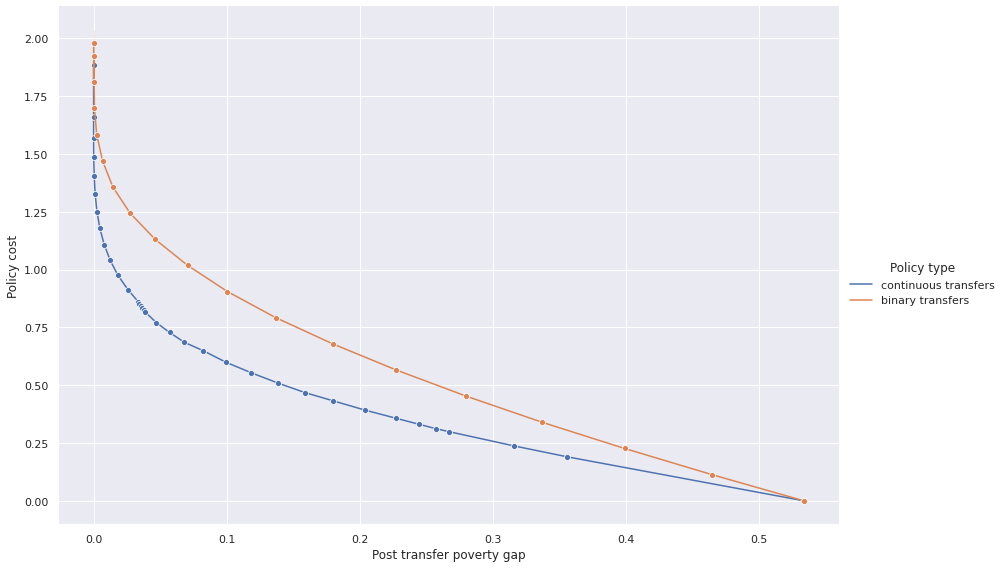

In [33]:
continuous_gap = pd.read_csv(results_path / 'top_line' / 'continuous_gap' / 'malawi.csv')

binary_gap = pd.read_csv(results_path / 'top_line' / 'binary_gap' / 'malawi.csv')

continuous_vs_binary_gap = pd.concat((continuous_gap, binary_gap))
continuous_vs_binary_gap.drop_duplicates(
    subset=[
        'policy_type', 'unconditional_tolerance', 'conditional_tolerance', 'd', 'nclass', 
        'features', 'budget', 'lambda'
    ],
    keep='last', inplace=True
)

continuous_vs_binary_gap.policy_type = continuous_vs_binary_gap.policy_type.map({'gap': 'continuous transfers', 'binary_gap': 'binary transfers'})
to_plot = continuous_vs_binary_gap.copy()

to_plot.rename(columns={'policy_type': 'Policy type'}, inplace=True)

fg = relplot(
    data=to_plot, x='post_transfer_poverty_gap', y='policy_cost_per_capita',
    hue='Policy type', kind='line', marker='o', height=8, aspect=12/8
)
fg.set(xlabel='Post transfer poverty gap', ylabel='Policy cost')
#sns.move_legend(fg, "upper right",bbox_to_anchor=(.8,.8))

In [36]:
max_post_transfer_gap = continuous_vs_binary_gap.groupby('policy_type').agg({'post_transfer_poverty_gap': 'max'}).min().values.item()
gaps_to_evaluate_ratios = np.linspace(0, max_post_transfer_gap, 40)

gap_ratios = evaluate_ratios(
    numerator_data=continuous_vs_binary_gap[continuous_vs_binary_gap.policy_type == 'binary transfers'],
    denominator_data=continuous_vs_binary_gap[continuous_vs_binary_gap.policy_type == 'continuous transfers'],
    desired_field='policy_cost_per_capita',
    matching_field='post_transfer_poverty_gap',
    matching_values=gaps_to_evaluate_ratios
)
gap_ratios = pd.DataFrame(
    np.array([gaps_to_evaluate_ratios, gap_ratios]).transpose(),
    columns=['post_transfer_poverty_gap', 'cost_ratio']
)
gap_ratios['policy_type'] = 'gap'
gap_ratios.dropna(inplace=True)


/data/tmp/ipykernel_1023930/3779580075.py:9: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


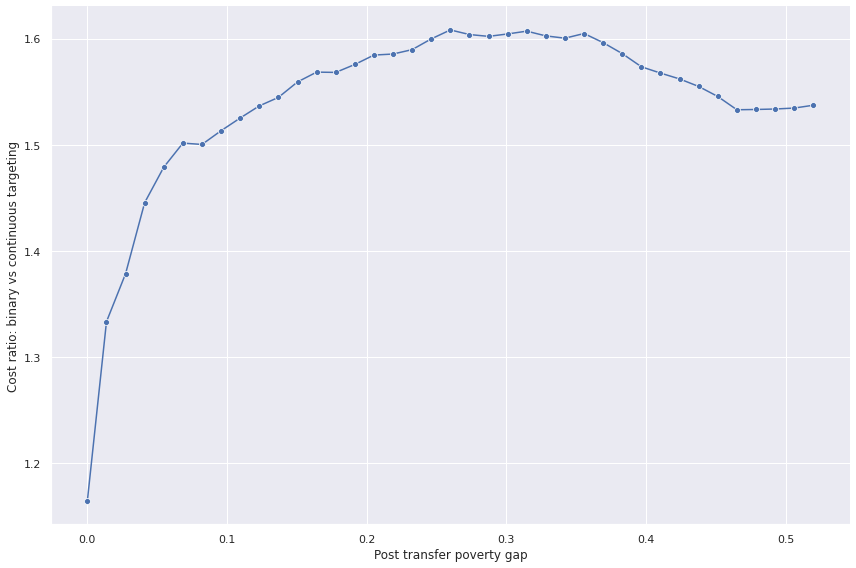

In [39]:
to_plot = gap_ratios.copy()

to_plot.rename(columns={'policy_type': 'Policy type'}, inplace=True)

fg = relplot(
    data=to_plot, x='post_transfer_poverty_gap', y='cost_ratio',
     kind='line', marker='o', height=8, aspect=12/8
)
fg.set(xlabel='Post transfer poverty gap', ylabel='Cost ratio: binary vs continuous targeting')
#sns.move_legend(fg, "upper right",bbox_to_anchor=(.8,.8))

### Gap main comparison

In [36]:
no_information_gap = pd.read_csv(results_path  / 'gap' / 'malawi.csv')
no_information_gap.features.unique()

array(['selected_durable', 'mosaiks', 'all_durable', '4_selected_durable',
       nan], dtype=object)

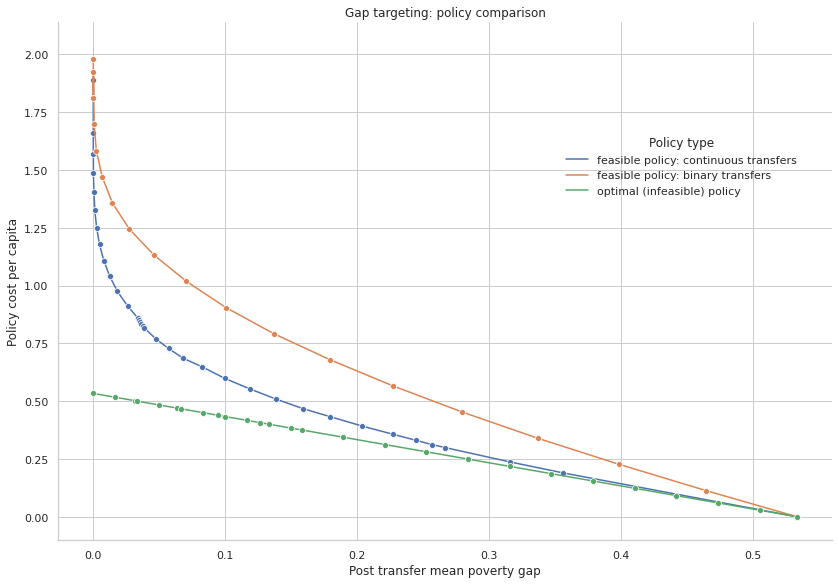

In [6]:
continuous_gap = pd.read_csv(results_path / 'top_line' / 'continuous_gap' / 'malawi.csv')

binary_gap = pd.read_csv(results_path / 'top_line' / 'binary_gap' / 'malawi.csv')

oracle_gap = pd.read_csv(results_path / 'top_line' / 'oracle_gap' / 'malawi.csv')

no_information_gap = pd.read_csv(results_path  / 'gap' / 'malawi.csv')

no_information_gap = no_information_gap[no_information_gap.features.isna()]
no_information_gap['policy_type'] = 'no_information_gap'

gap_comparison = pd.concat((continuous_gap, binary_gap, oracle_gap))
gap_comparison.drop_duplicates(
    subset=[
        'policy_type', 'unconditional_tolerance', 'conditional_tolerance', 'd', 'nclass', 
        'features', 'budget', 'lambda', 
    ],
    keep='last', inplace=True
)

gap_comparison.policy_type = gap_comparison.policy_type.map({
    'gap': 'feasible policy: continuous transfers', 'binary_gap': 'feasible policy: binary transfers', 
    'oracle_gap': 'optimal (infeasible) policy', 'no_information_gap': 'uniform transfers'
})
to_plot = gap_comparison.copy()

to_plot.rename(columns={'policy_type': 'Policy type'}, inplace=True)
sns.set_style("whitegrid")

fg = relplot(
    data=to_plot, x='post_transfer_poverty_gap', y='policy_cost_per_capita',
    hue='Policy type', kind='line', marker='o', height=8, aspect=12/8
)
fg.set(xlabel='Post transfer mean poverty gap', ylabel='Policy cost per capita', title='Gap targeting: policy comparison')
sns.move_legend(fg, "upper right",bbox_to_anchor=(.75,.8))


### Tolerance vs post-transfer metrics

#### Rate targeting

In [114]:
continuous_unconditional_rate = pd.read_csv(results_path / 'top_line' / 'continuous_unconditional_rate' / 'malawi.csv')
continuous_unconditional_rate.rename(columns={'method': 'policy_type'}, inplace=True)

continuous_unconditional_rate.drop_duplicates(
    subset=[
        'policy_type', 'unconditional_tolerance', 'conditional_tolerance', 'd', 'nclass', 
        'features',
    ],
    keep='last', inplace=True
)
continuous_unconditional_rate.policy_type = 'rate targeting'

/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


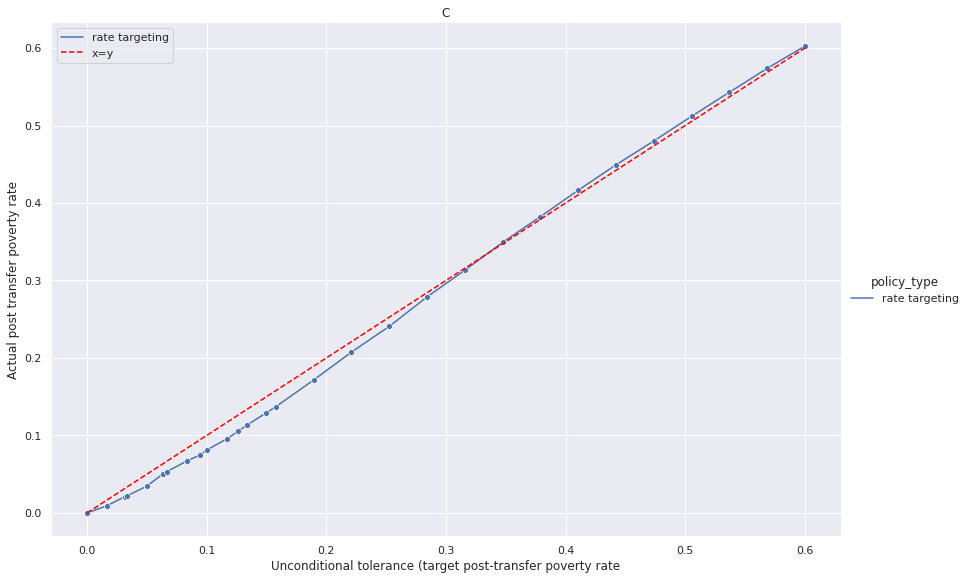

In [119]:
to_plot = continuous_unconditional_rate.copy()

fg = relplot(
    data=to_plot, x='unconditional_tolerance', y='post_transfer_poverty_rate',
    kind='line', hue='policy_type', marker='o', height=8, aspect=12/8, legend=True
)
for ax in fg.figure.axes:
    
    sns.lineplot(
        data=to_plot,
        x='unconditional_tolerance', y='unconditional_tolerance',
        color='red',
        linestyle='--',
        label='x=y',
        ax=ax,
        legend=True
    )
fg.set(xlabel='Unconditional tolerance (target post-transfer poverty rate', ylabel='Actual post transfer poverty rate', title='C')
#sns.move_legend(fg, "upper right",bbox_to_anchor=(.8,.8))

## Presentation plots Nov 13 2024

In [48]:
gap_comparison.method.value_counts()

method
feasible policy: 30 LSMS covariates     40
feasible policy: MOSAIKS covariates     40
feasible policy: 147 LSMS covariates    40
feasible policy: 4 LSMS covariates      40
Name: count, dtype: int64

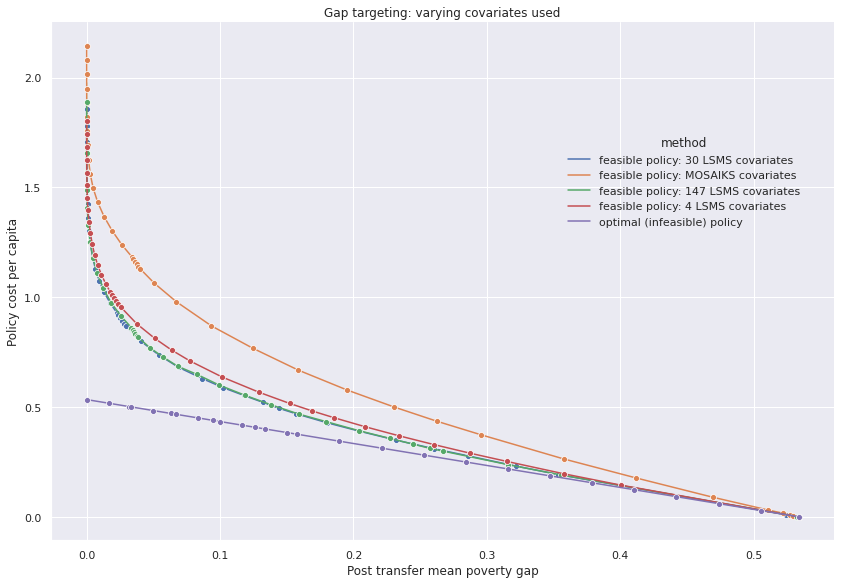

In [49]:
gap_targeting_results = pd.read_csv(results_path / 'gap' / 'malawi.csv')

gap_targeting_results.loc[gap_targeting_results.features == 'selected_durable', 'method'] = (
    'feasible policy: 30 LSMS covariates'
)
gap_targeting_results.loc[gap_targeting_results.features == 'all_durable', 'method'] = (
    'feasible policy: 147 LSMS covariates'
)
gap_targeting_results.loc[gap_targeting_results.features == '4_selected_durable', 'method'] = (
    'feasible policy: 4 LSMS covariates'
)

gap_targeting_results.loc[gap_targeting_results.features == 'mosaiks', 'method'] = (
    'feasible policy: MOSAIKS covariates'
)

oracle_gap = pd.read_csv(results_path / 'top_line' / 'oracle_gap' / 'malawi.csv')
oracle_gap['method'] = 'optimal (infeasible) policy'

gap_comparison = pd.concat((gap_targeting_results, oracle_gap))
gap_comparison.drop_duplicates(
    subset=[
        'method', 'unconditional_tolerance', 'conditional_tolerance', 'd', 'nclass', 
        'features', 'lambda', 'n_quantiles', 'hidden_layer_size', 
    ],
    keep='last', inplace=True
)

to_plot = gap_comparison
fg = relplot(
    data=to_plot, kind='line',
    x="post_transfer_poverty_gap", y="policy_cost_per_capita", hue="method",
    marker='o', height=8, aspect=12/8
)
fg.set(
    xlabel='Post transfer mean poverty gap', ylabel='Policy cost per capita',
    title='Gap targeting: varying covariates used'
)
sns.move_legend(fg, "upper right",bbox_to_anchor=(.75,.8))


# Binary gap targeting

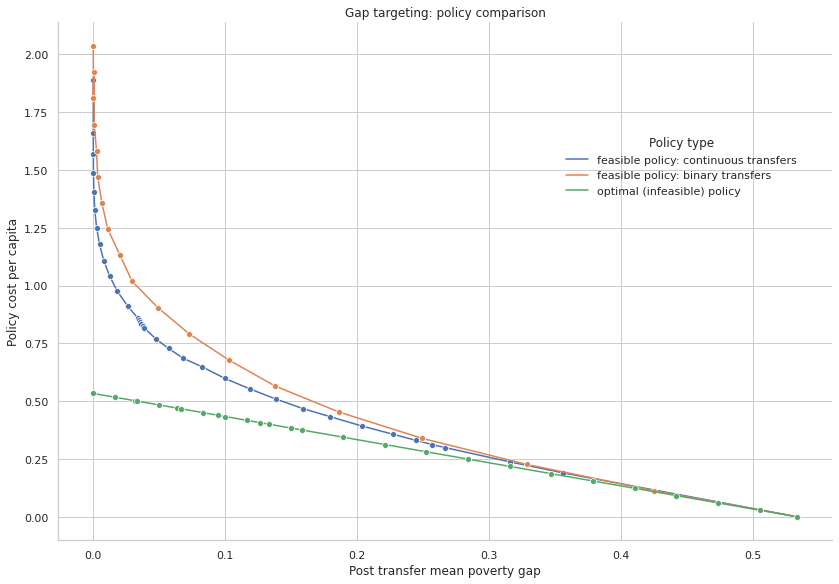

In [ ]:
continuous_gap = pd.read_csv(results_path / 'top_line' / 'continuous_gap' / 'malawi.csv')

binary_gap = pd.read_csv(results_path / 'binary_gap' / 'malawi.csv')

oracle_gap = pd.read_csv(results_path / 'top_line' / 'oracle_gap' / 'malawi.csv')

gap_comparison = pd.concat((continuous_gap, binary_gap, oracle_gap))
gap_comparison.drop_duplicates(
    subset=[
        'policy_type', 'unconditional_tolerance', 'conditional_tolerance', 'd', 'nclass', 
        'features', 'budget', 'lambda', 
    ],
    keep='last', inplace=True
)

gap_comparison.policy_type = gap_comparison.policy_type.map({
    'gap': 'feasible policy: continuous transfers', 'binary_gap': 'feasible policy: binary transfers', 
    'oracle_gap': 'optimal (infeasible) policy', 'no_information_gap': 'uniform transfers'
})
to_plot = gap_comparison.copy()

to_plot.rename(columns={'policy_type': 'Policy type'}, inplace=True)
sns.set_style("whitegrid")

fg = relplot(
    data=to_plot, x='post_transfer_poverty_gap', y='policy_cost_per_capita',
    hue='Policy type', kind='line', marker='o', height=8, aspect=12/8
)
fg.set(xlabel='Post transfer mean poverty gap', ylabel='Policy cost per capita', title='Gap targeting: policy comparison')
sns.move_legend(fg, "upper right",bbox_to_anchor=(.75,.8))


# Subnational analysis

In [7]:
def plot_with_faceting(df, x_column, y_column, x_label, y_label, line_grouping_column, faceting_column, country):

    facet_groups = df.groupby(faceting_column)

    fig, axs = plt.subplots(2, math.ceil(len(facet_groups)/2), figsize=(12, 8), sharey=True) 
    for i, (facet_label, group) in enumerate(facet_groups):
        # Determine subplot index
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        # Iterate over groups
        for group_label, group in group.groupby(line_grouping_column):
            # Plot y_column against x_column
            ax.plot(group[x_column], group[y_column], label=group_label, marker="o")

        if 'tolerance' in x_column and y_column == "post_transfer_poverty_rate":
            ax.plot(group[x_column], group[x_column], label="y=x", linestyle="dashed", color="black")

        # Add labels and title to each subplot
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(f'{faceting_column} = {facet_label}')
        legend = ax.legend()
        legend.set_title(line_grouping_column)

        # Add grid
        ax.grid(True)

    # Adjust layout and display plot
    plt.suptitle("{}: {} vs. {}".format(country, y_label, x_label))
    plt.tight_layout()
    plt.savefig(figs_path / "{}_{}_{}.pdf".format(country.lower(), x_column, y_column))
    plt.show()


def plot_without_faceting(
    df, x_column, y_column, x_label, y_label, line_grouping_column, country
):

    fig, ax = plt.subplots(1,1, figsize=(12, 8)) 

    # Iterate over groups
    for group_label, group in df.groupby(line_grouping_column):
        # Plot y_column against x_column
        ax.plot(group[x_column], group[y_column], label=group_label, marker="o")

    if 'tolerance' in x_column and y_column == "post_transfer_poverty_rate":
        ax.plot(group[x_column], group[x_column], label="y=x", linestyle="dashed", color="black")

    # Add labels and title to each subplot
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    legend = ax.legend()
    legend.set_title(line_grouping_column)


    # Add grid
    ax.grid(True)

    # Adjust layout and display plot
    plt.suptitle("{}: {} vs. {}".format(country, y_label, x_label))
    
    plt.tight_layout()
    plt.savefig(figs_path / "{}_{}_{}.pdf".format(country.lower(), x_column, y_column))
    plt.show()

def scatter_plots(
    df, x_column, y_columns, x_label, y_labels, row_for_line, subplots_with_line, country, bars_below_column=None,
    bars_below_label=None
):

    num_rows = math.ceil(len(y_columns)/2)
    num_cols = 2


    if bars_below_column:
        gs = gridspec.GridSpec(3 * num_rows, 2, height_ratios=num_rows * [2, 1, 1], hspace=0.0) 
        fig = plt.figure(figsize=(8*num_cols ,6*num_rows))

    else:
        gs = gridspec.GridSpec(num_rows, 2, height_ratios=num_rows * [1]) 
        fig = plt.figure(figsize=(8*num_cols , 8*num_rows))

    if not subplots_with_line:
        subplots_with_line = []

    for i, (y_column, y_label) in enumerate(zip(y_columns, y_labels)):

        col = i % 2

        # Determine subplot index
        if bars_below_column:
            row = (i // 2) * 3
            ax_bars = fig.add_subplot(gs[row+1, col] )
            ax_main = fig.add_subplot(gs[row, col], sharex=ax_bars)

        else:
            row = i // 2
            ax_main = fig.add_subplot(gs[row, col])

        ax_with_x_axis = ax_bars if bars_below_column else ax_main
        ax_with_x_axis.tick_params(axis='x', labelrotation=90) 

        sorted = df.sort_values(y_column)

        ax_main.scatter(
            sorted[x_column], sorted[y_column], color='k'
        )
        ax_main.set_ylabel(y_label)

        if bars_below_column:
            ax_bars.bar(sorted[x_column], sorted[bars_below_column])
            ax_bars.set_ylabel(bars_below_label if bars_below_label else bars_below_column)
            plt.setp(ax_main.get_xticklabels(), visible=False)

        # Add labels and title to each subplot
        if x_label:
            ax_with_x_axis.set_xlabel(x_label)

        if i in subplots_with_line:
            ax_main.axhline(y=row_for_line[y_column].values, label=row_for_line[x_column], color='b')
            ax_main.text(
                22, row_for_line[y_column].values + 0.02, 'Entire Country', color='b', verticalalignment='bottom'
            )

    fig.tight_layout()
    # fig.subplots_adjust(hspace=0.0)
    fig.savefig(figs_path / "{}_{}_{}.pdf".format(country.lower(), x_column, y_column))

In [ ]:
df = pd.read_csv(results_path /'results_for_subnational_analysis' / 'malawi.csv')

df['total_cost'] = df['policy_cost_per_capita'] * df['weight_adjusted_population']
df['initial_poverty_count'] = df['initial_poverty_rate'] * df['weight_adjusted_population']
df['post_transfer_poverty_count'] = df['post_transfer_poverty_rate'] * df['weight_adjusted_population']
df['initial_total_poverty_gap'] = df['initial_poverty_gap'] * df['weight_adjusted_population']
df['post_transfer_total_poverty_gap'] = df['post_transfer_poverty_gap'] * df['weight_adjusted_population']

df['poverty_count_reduction'] = (df.initial_poverty_count- df.post_transfer_poverty_count)
df['total_poverty_gap_reduction'] = (df.initial_total_poverty_gap - df.post_transfer_total_poverty_gap)

df['cost_per_poverty_count_reduction'] = df['total_cost'] / df.poverty_count_reduction
df['cost_per_total_poverty_gap_reduction'] = df['total_cost'] / df.total_poverty_gap_reduction

df['poverty_rate_reduction'] = (df.initial_poverty_rate- df.post_transfer_poverty_rate)
df['poverty_gap_reduction'] = (df.initial_poverty_gap - df.post_transfer_poverty_gap)

full_country = df[df.features == 'full_country']
df = df[df.features != 'full_country']

In [65]:
gs = gridspec.GridSpec(2, 2,  height_ratios= [2, 1]) 

In [69]:
gs[0]

GridSpec(2, 2, height_ratios=[2, 1])[0:1, 0:1]

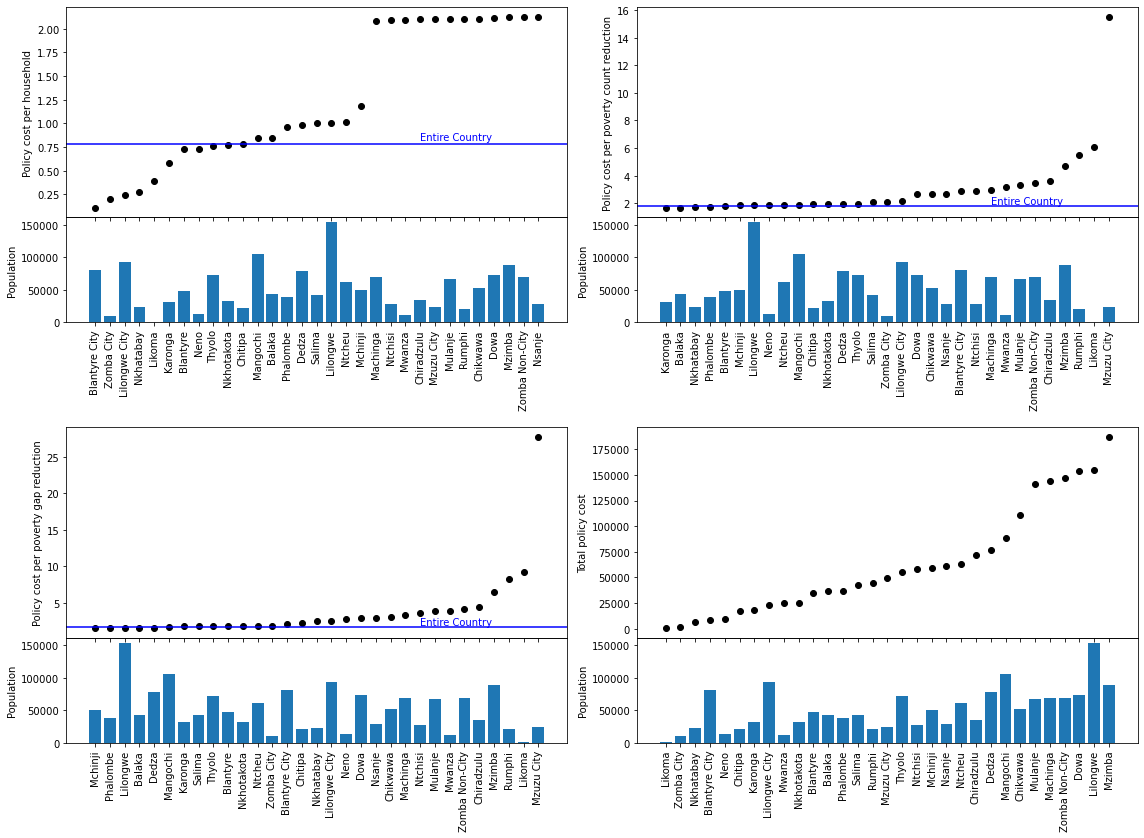

In [139]:
scatter_plots(
    df[
        (df['unconditional_tolerance'] == 0.2)
    ],
    x_column='features',
    y_columns = [
        'policy_cost_per_capita', 'cost_per_poverty_count_reduction', 'cost_per_total_poverty_gap_reduction', 'total_cost'
    ],
    x_label=None,
    y_labels = ['Policy cost per household', 'Policy cost per poverty count reduction', 'Policy cost per poverty gap reduction', 'Total policy cost'],
    country='Malawi',
    row_for_line=full_country,
    subplots_with_line=[0,1,2],
    bars_below_column='weight_adjusted_population',
    bars_below_label='Population'
)

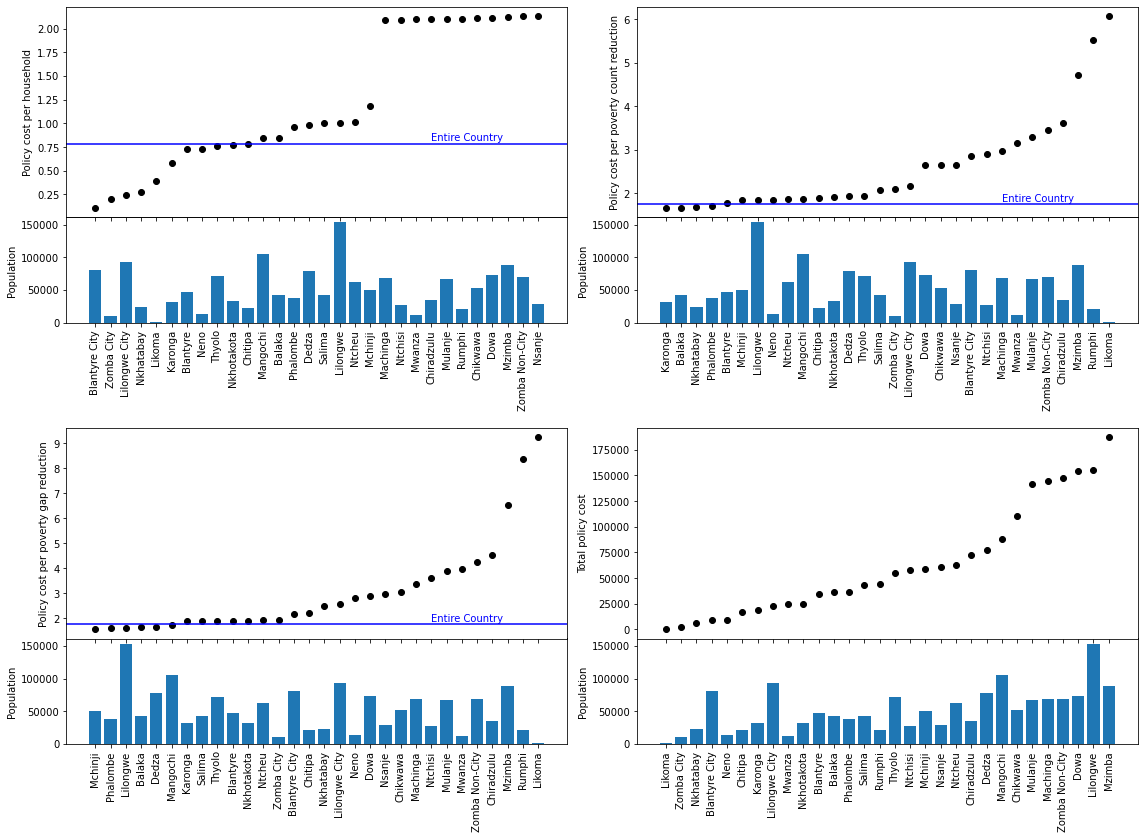

In [142]:
scatter_plots(
    df[
        (df['unconditional_tolerance'] == 0.2)
        & (df['features'] != 'Mzuzu City')
    ],
    x_column='features',
    y_columns = [
        'policy_cost_per_capita', 'cost_per_poverty_count_reduction', 'cost_per_total_poverty_gap_reduction', 'total_cost'
    ],
    x_label=None, 
    y_labels = ['Policy cost per household', 'Policy cost per poverty count reduction', 'Policy cost per poverty gap reduction', 'Total policy cost'],
    country='Malawi',
    row_for_line=full_country,
    subplots_with_line=[0,1,2],
    bars_below_column='weight_adjusted_population',
    bars_below_label='Population'
)

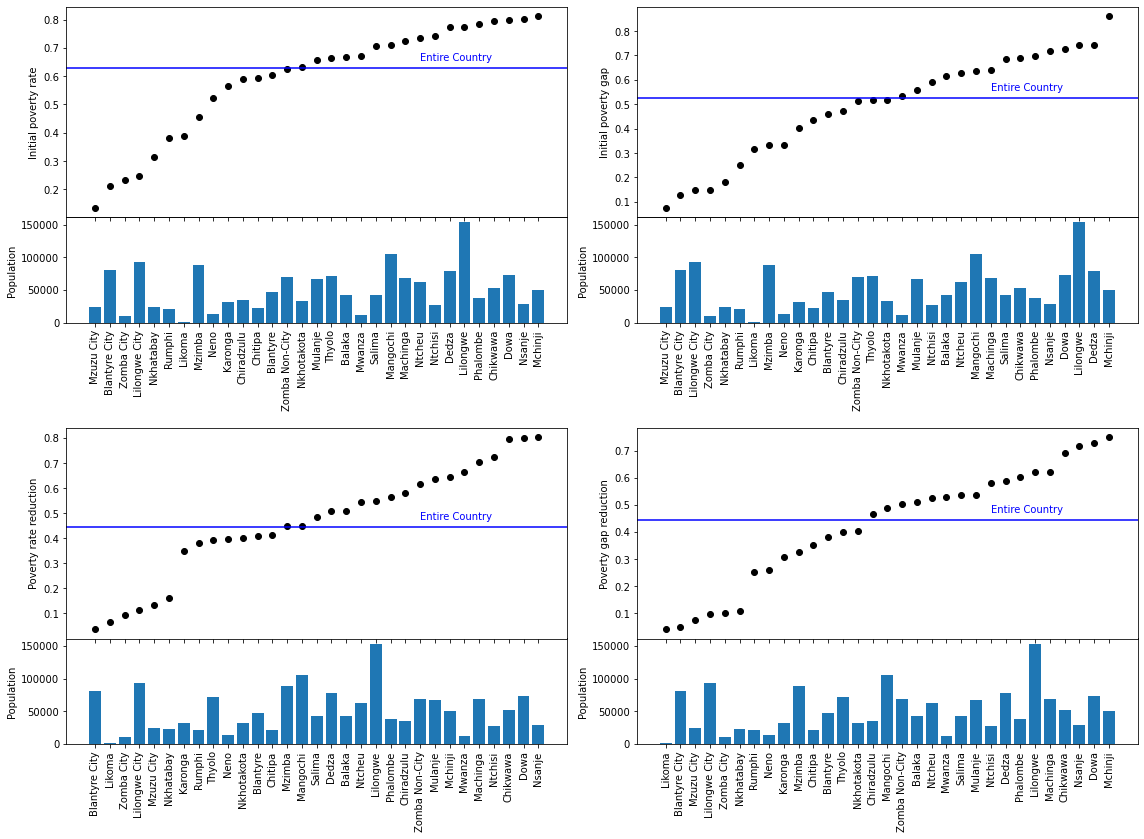

In [143]:
scatter_plots(
    df[
        (df['unconditional_tolerance'] == 0.2)
    ],
    x_column='features',
    y_columns = [
        'initial_poverty_rate', 'initial_poverty_gap', 'poverty_rate_reduction', 'poverty_gap_reduction'
    ],
    x_label=None, 
    y_labels = ['Initial poverty rate', 'Initial poverty gap', 'Poverty rate reduction', 'Poverty gap reduction'],
    country='Malawi',
    row_for_line=full_country,
    subplots_with_line=[0,1,2, 3],
    bars_below_column='weight_adjusted_population',
    bars_below_label='Population'
)